# Research Assitant - Language Anxiety - 3 - FastText

## Installing Package

In [ ]:
# !pip install xgboost lightgbm catboost
# !pip uninstall -y scikit-learn
# !pip install scikit-learn==1.3.1

## Importing Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import cross_val_predict, StratifiedKFold, train_test_split, GridSearchCV

## Model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC

## Utils
from sklearn.utils import shuffle, class_weight

## Text Representation
from sklearn.feature_extraction.text import TfidfVectorizer

## Model Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, f1_score, make_scorer, accuracy_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_validate

# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier

## **Reading The Dataset**

In [ ]:
df = pd.read_excel('/content/Clean_Merged_Anxiety_Dataset_Updated AI Label.xlsx')
df = df[df['is_ai_generated_label'] == 0]
df = df[["Post", "LA Class"]]

# Pisahkan kelas anxiety
# df_anxiety = df[df["LA Class"] == "Anxiety"]
# df_no_anxiety = df[df["LA Class"] == "No Anxiety"]

# Sampling data anxiety supaya jadi sekitar 60 baris
# df_anxiety_sampled = df_anxiety.sample(n=150, random_state=42)  # Random sampling 60 baris

# Gabungkan kembali data yang sudah disampling
# df = pd.concat([df_anxiety_sampled, df_no_anxiety], ignore_index=True)

df.head()

,Post,LA Class
1,The innovation of technology has transformed a...,Anxiety
3,Lack of sexual education in children in Indone...,No Anxiety
4,Imagine no longer needing to be stuck in traff...,Anxiety
5,Eco-friendly is a way of living without harmin...,Anxiety
6,"With the Increasing focus on Generative Al, 20...",No Anxiety


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 216 entries, 1 to 356
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Post      216 non-null    object
 1   LA Class  216 non-null    object
dtypes: object(2)
memory usage: 5.1+ KB


## Checking Class Distribution

LA Class
Anxiety       168
No Anxiety     48
Name: count, dtype: int64



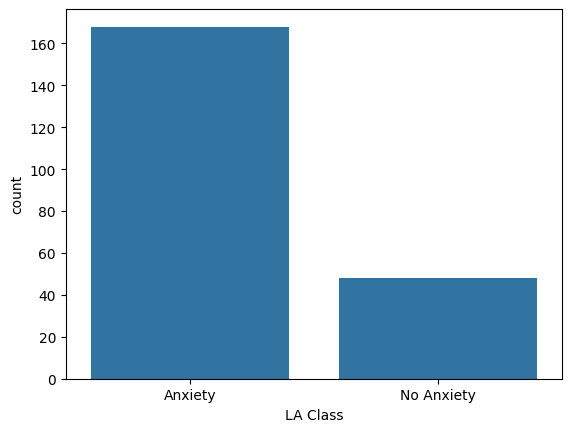

In [ ]:
print(df['LA Class'].value_counts())
print()

# create LA Classification visualization
sns.countplot(x='LA Class', data=df)
plt.show()

## **Encode The Target Variable**

In [ ]:
# Menggunakan mapping manual dengan map
df['la_class'] = df['LA Class'].map({'Anxiety': 1, 'No Anxiety': 0})

# Menampilkan hasil
print("Mapping kelas ke nilai encoded:")
print(df[['LA Class', 'la_class']])

# Menghapus kolom asli
df.drop(columns=['LA Class'], inplace=True)

Mapping kelas ke nilai encoded:
       LA Class  la_class
1       Anxiety         1
3    No Anxiety         0
4       Anxiety         1
5       Anxiety         1
6    No Anxiety         0
..          ...       ...
347     Anxiety         1
351  No Anxiety         0
354     Anxiety         1
355     Anxiety         1
356     Anxiety         1

[216 rows x 2 columns]


In [ ]:
df.head()

,Post,la_class
1,The innovation of technology has transformed a...,1
3,Lack of sexual education in children in Indone...,0
4,Imagine no longer needing to be stuck in traff...,1
5,Eco-friendly is a way of living without harmin...,1
6,"With the Increasing focus on Generative Al, 20...",0


## Text Preprocessing

### Contraction Mapping

In [ ]:
contraction_mapping = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he had",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how does",
    "I'd": "I had",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she had",
    "she'd've": "she would have",
    "she'll": "she she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that had",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they had",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
}

def expand_contractions(text, contraction_mapping):
    for contraction, expanded in contraction_mapping.items():
        text = text.replace(contraction, expanded)
    return text

df['Post'] = df['Post'].apply(lambda x: expand_contractions(x, contraction_mapping))

### Text Cleaning

In [ ]:
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Ambil kata-kata hentian bahasa Inggris
all_stopwords = set(stopwords.words('english'))

# Hapus kata 'not' dari daftar kata hentian
all_stopwords.discard('not')

# Tambahkan kata-kata negasi lainnya
negations = {"n't", "no", "never", "none", "nothing", "neither", "nowhere", "nor", "cannot", "can't", "didn't", "doesn't", "don't", "hadn't", "hasn't", "haven't", "isn't", "shouldn't", "wasn't", "weren't", "won't", "wouldn't"}

# Perbarui daftar kata hentian dengan menghapus kata-kata negasi
all_stopwords = all_stopwords - negations

# Konversi kembali ke list jika diperlukan
all_stopwords = list(all_stopwords)

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Hapus karakter non-alphanumeric
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Konversi teks ke huruf kecil
    text = text.lower()
    # Split teks menjadi kata-kata
    words = text.split()
    # Lematisasi dan hapus stop words
    words = [lemmatizer.lemmatize(word) for word in words]
    # Gabungkan kata-kata kembali menjadi satu string
    processed_text = ' '.join(words)

    return processed_text

df['Post'] = df['Post'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Feature Extraction Using Fasttext

In [ ]:
import gensim.downloader as api

# Mengunduh model FastText yang sudah dilatih sebelumnya
ft = api.load('fasttext-wiki-news-subwords-300')

def get_word_vector(word):
    try:
        return ft[word]
    except KeyError:
        return np.zeros(300)

def document_vector(document):
    words = document.split()
    word_vectors = [get_word_vector(word) for word in words]
    return np.mean(word_vectors, axis=0)

df['Post'] = df['Post'].apply(document_vector)
df.head()

[==================================================] 100.0% 958.5/958.4MB downloaded


,Post,la_class
1,"[0.000751812, -0.008931949, 0.011391009, 0.006...",1
3,"[-0.0035116989629182427, -0.004843380280097212...",0
4,"[0.0004592815623993266, -0.011211412429687392,...",1
5,"[0.006016307491619478, -0.006223939658377048, ...",1
6,"[-7.392027108767383e-05, -0.010001488544105869...",0


## Splitting The Data

In [ ]:
X = df.drop('la_class', axis=1)
y = df['la_class']

In [ ]:
post_vectors = np.array(X['Post'].tolist())

## Defining Models

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(class_weight='balanced'),
    # "XGBoost": XGBClassifier(scale_pos_weight=(len(y) - sum(y)) / sum(y)),
    # "LightGBM": LGBMClassifier(scale_pos_weight=(len(y) - sum(y)) / sum(y)),
    # "CatBoost": CatBoostClassifier(scale_pos_weight=(len(y) - sum(y)) / sum(y))
}

## Defining Cross Validation

In [ ]:
cv = StratifiedKFold(n_splits=5)

## Calculating Each Model Performance

In [ ]:
results = []
for model_name, model in models.items():
    scores = cross_validate(model, post_vectors, y, cv=cv, scoring=['accuracy', 'precision', 'recall', 'f1', 'f1_weighted'])

    results.append({
        'Model': model_name,
        'Accuracy': scores['test_accuracy'].mean(),
        'Precision': scores['test_precision'].mean(),
        'Recall': scores['test_recall'].mean(),
        'F1-score': scores['test_f1'].mean(),
        'Weighted F1-score': scores['test_f1_weighted'].mean()
    })

results_df = pd.DataFrame(results)

In [ ]:
results_df

,Model,Accuracy,Precision,Recall,F1-score,Weighted F1-score
0,Logistic Regression,0.629387,0.824172,0.664706,0.729529,0.647453
1,Decision Tree,0.643340,0.779287,0.755971,0.766120,0.647739
2,Random Forest,0.773150,0.776694,0.993939,0.871957,0.678313
3,Naive Bayes,0.685201,0.787801,0.808021,0.795512,0.678817
4,SVM,0.694503,0.783773,0.831551,0.803487,0.677194


## Model Performances Visualization

### Accuracy

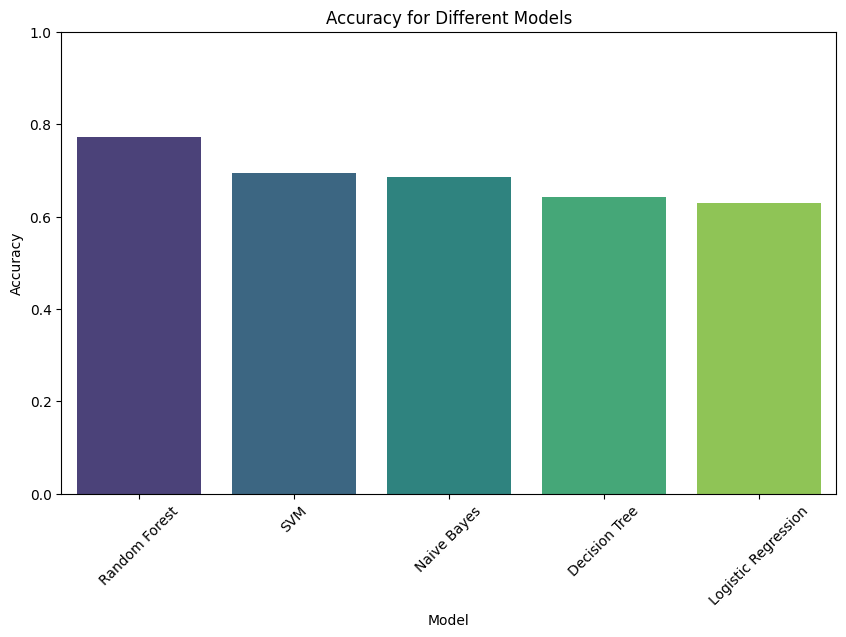

In [ ]:
plt.figure(figsize=(10, 6))
sorted_df = results_df.sort_values(by='Accuracy', ascending=False)
sns.barplot(x='Model', y='Accuracy', data=sorted_df, palette='viridis')
plt.title('Accuracy for Different Models')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

### Precision

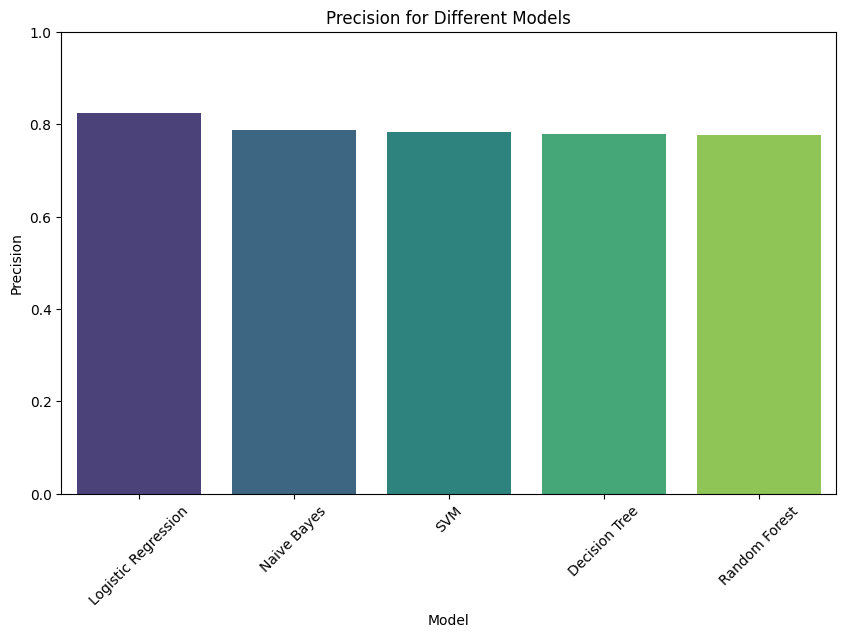

In [ ]:
plt.figure(figsize=(10, 6))
sorted_df = results_df.sort_values(by='Precision', ascending=False)
sns.barplot(x='Model', y='Precision', data=sorted_df, palette='viridis')
plt.title('Precision for Different Models')
plt.ylabel('Precision')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

### Recall

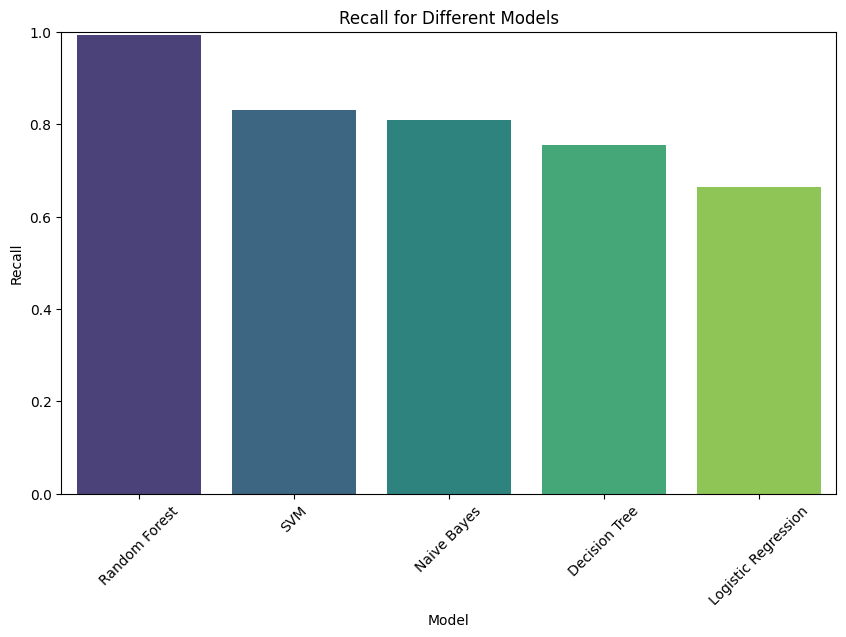

In [ ]:
plt.figure(figsize=(10, 6))
sorted_df = results_df.sort_values(by='Recall', ascending=False)
sns.barplot(x='Model', y='Recall', data=sorted_df, palette='viridis')
plt.title('Recall for Different Models')
plt.ylabel('Recall')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

### F1-score

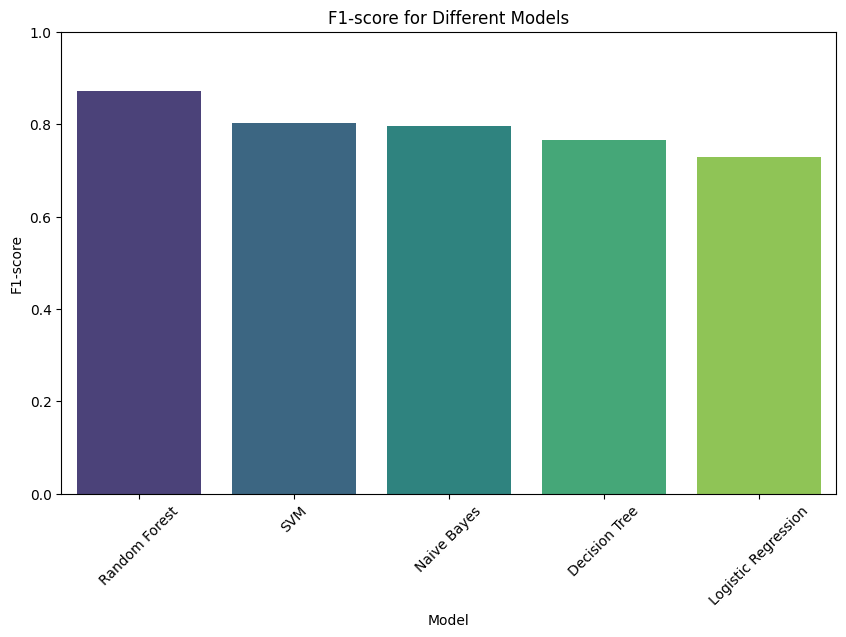

In [ ]:
plt.figure(figsize=(10, 6))
sorted_df = results_df.sort_values(by='F1-score', ascending=False)
sns.barplot(x='Model', y='F1-score', data=sorted_df, palette='viridis')
plt.title('F1-score for Different Models')
plt.ylabel('F1-score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

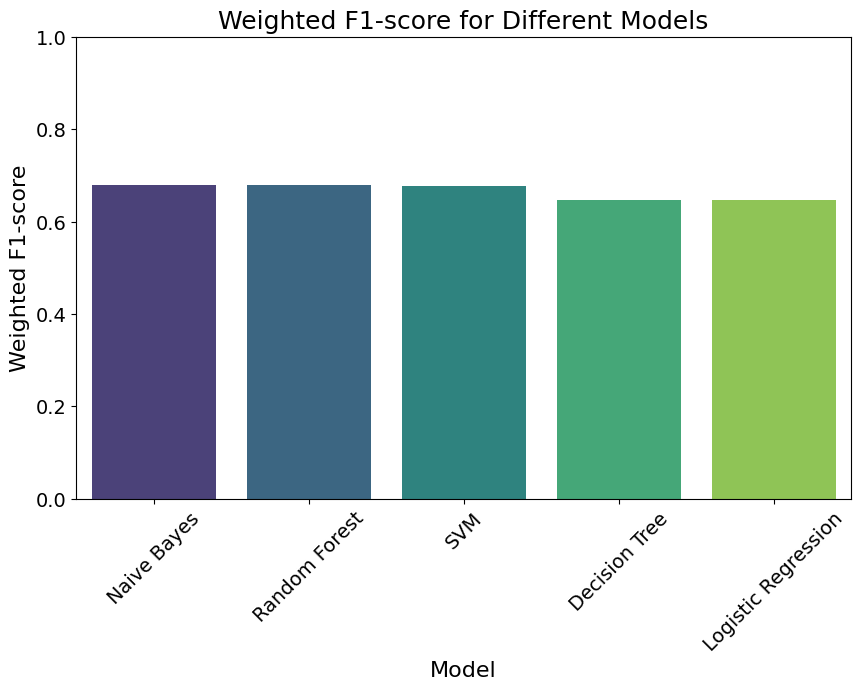

In [ ]:
plt.figure(figsize=(10, 6))
sorted_df = results_df.sort_values(by='Weighted F1-score', ascending=False)
sns.barplot(x='Model', y='Weighted F1-score', data=sorted_df, palette='viridis')
plt.title('Weighted F1-score for Different Models', fontsize=18)
plt.ylabel('Weighted F1-score', fontsize=16)
plt.xlabel('Model', fontsize=16)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)  # Memperbesar ukuran font ticks sumbu y
plt.ylim(0, 1)
plt.show()